In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', 
    # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', 
    # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, 
    # порт подключения
    'db': 'data-analyst-advanced-sql' 
    # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query1 = '''
SELECT DATE_TRUNC('month', sp.creation_date) AS month_date,
       SUM(sp.views_count) AS total_views
FROM stackoverflow.posts AS sp
WHERE EXTRACT(YEAR FROM creation_date::DATE) = 2008
GROUP BY DATE_TRUNC('month', sp.creation_date)
ORDER BY total_views DESC;
'''

# выполните запрос
data_1 = pd.read_sql_query(query1, con=engine) 
data_1.head()

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083


<details>

<summary>Подсказка</summary>
Используйте функцию для усечения даты, а затем сгруппируйте и отсортируйте данные.
</details>

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

**Напишите ваш ответ здесь:**

Наблюдается сезонность, то есть к летним месяцам, когда наибольшее количество отпусков, работает меньшее количестов людей
в следствии чего и меньшее число просмотров постов. И наоборот в сентябре, когда начинается учеба у детей и студентов, 
а также отпускной сезон заканчивается, количество просмотров постов изза накопившихся за лето нерешенных вопросов максимальное.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query2 = '''
SELECT dname,
       COUNT(id_user) AS cnt_id 
FROM
    (SELECt DISTINCT dname,
            id_user,
            SUM(cnt) AS total_cnt
    FROM
        (SELECT su.id AS id_user,
               su.display_name AS dname,
               su.creation_date AS dtu,
               sp.creation_date AS dtp,
               (su.creation_date + INTERVAL '31 day') AS interval_date,
               COUNT(spt.type) AS cnt
        FROM stackoverflow.users AS su
        JOIN stackoverflow.posts AS sp ON su.id = sp.user_id
        JOIN stackoverflow.post_types AS spt ON sp.post_type_id = spt.id
        WHERE spt.type = 'Answer' 
        GROUP BY id_user,
                 dname,
                 dtu,
                 dtp) AS one_temp_table
    WHERE dtp BETWEEN dtu AND interval_date
    GROUP BY dname,
             id_user,
             cnt) AS two_temp_table
WHERE total_cnt > 100
      AND dname IN (SELECT DISTINCT su.display_name
                    FROM stackoverflow.users AS su)
GROUP BY dname
ORDER BY dname ASC
'''

# выполните запрос
data_2 = pd.read_sql_query(query2, con=engine) 
data_2.head()

,dname,cnt_id
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

Какие аномалии наблюдаются в данных? О чём они говорят?

**Напишите ваш ответ здесь:**
    
Поле с именем пользователя хаотичное, видимо нет правила по которому его разрешено заполнять.
Количество уникальных номеров пользователя, везде равно 1 т.к. нет двух одинаковых пользователей.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query3 = '''
SELECT DATE_TRUNC('month', sp.creation_date) AS month_date,
       COUNT(sp.id) AS cnt
FROM stackoverflow.posts AS sp
WHERE EXTRACT(YEAR FROM sp.creation_date::DATE) = 2008
      AND sp.user_id IN (SELECT su.id AS su_user_id
                         FROM stackoverflow.users AS su
                         JOIN stackoverflow.posts AS sp ON su.id = sp.user_id
                         WHERE EXTRACT(YEAR FROM su.creation_date::DATE) = 2008 
                               AND EXTRACT(MONTH FROM su.creation_date::DATE) = 9
                               AND EXTRACT(MONTH FROM sp.creation_date::DATE) = 12)
GROUP BY DATE_TRUNC('month', sp.creation_date)
ORDER BY DATE_TRUNC('month', sp.creation_date) DESC;
'''

# выполните запрос
data_3 = pd.read_sql_query(query3, con=engine) 
data_3.head()

,month_date,cnt
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые зарегистрировались в сентябре 2008 года и оставили хотя бы один пост в декабре. Затем используйте результат для среза и посчитайте посты по месяцам.</details>

Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Напишите ваш ответ здесь**

Замечено две аномалии:
1. В августе возможно был только запущен данный функционал с размещением постов, поэтому число крайне мало.
2. Сентябрь и октябрь в полтора раза отличаются по числам от ноября и декабря. 
   Всплекс в сентябре вызван выходом сервиса на полную рабочую мощность, а затухание к декабрю обусловлено праздниками.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query4 = '''
SELECT sp.user_id,
       sp.creation_date,
       sp.views_count,
       SUM(views_count) OVER (PARTITION BY sp.user_id  ORDER BY sp.creation_date) AS cumulative_count
FROM stackoverflow.posts AS sp
'''

# выполните запрос
data_4 = pd.read_sql_query(query4, con=engine) 
data_4.head()

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509


<details>

<summary>Подсказка</summary>
Для подсчёта суммы с накоплением используйте оконную функцию.
</details>

# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query5 = '''
SELECT sp.user_id,
       (CAST(COUNT(sp.id) AS NUMERIC) / COUNT(DISTINCT sp.creation_date::DATE)) AS division
FROM stackoverflow.posts AS sp
WHERE (sp.creation_date::DATE BETWEEN '2008-08-01' AND '2008-08-31')
      AND sp.user_id IN (SELECT sp_user_id
                         FROM
                            (SELECT sp.user_id AS sp_user_id,
                                    COUNT(sp.id) AS cnt
                            FROM stackoverflow.posts AS sp
                            WHERE EXTRACT(MONTH FROM sp.creation_date::DATE) = 8
                                  AND EXTRACT(YEAR FROM sp.creation_date::DATE) = 2008
                            GROUP BY sp_user_id) AS one_temp
                         WHERE cnt > 120)
GROUP BY sp.user_id
ORDER BY division
'''

# выполните запрос
data_5 = pd.read_sql_query(query5, con=engine) 
data_5.head()

,user_id,division
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


<details>

<summary>Подсказка</summary>
Сначала найдите идентификаторы пользователей, которые написали более 120 постов за август. Используя этот запрос в качестве подзапроса для среза, найдите и сохраните во временную таблицу идентификаторы нужных пользователей, дни августа и количество постов в день. В основном запросе сгруппируйте данные по пользователям и найдите для каждого из них среднее количество постов.
</details>

# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query6 = '''
WITH i AS
    (SELECT id_user,
           COUNT(dt) AS act_day_cnt
    FROM
        (SELECT sp.user_id AS id_user,
                DATE_TRUNC('day', sp.creation_date) AS dt,
                COUNT(sp.id) AS cnt
         FROM stackoverflow.posts AS sp
         WHERE sp.creation_date BETWEEN '2008-12-01' AND '2008-12-07'
         GROUP BY sp.user_id,
                  DATE_TRUNC('day', sp.creation_date)) AS temp_table
    GROUP BY id_user)
SELECT ROUND(AVG(act_day_cnt),0) AS result
FROM i
'''

# выполните запрос
data_6 = pd.read_sql_query(query6, con=engine) 
data_6.head()

,result
0,2.0


<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Напишите ваш ответ здесь**

В среднем, в период с 1 по 7 декабря 2008 года, пользователи взаимодействовали с платформой 2 дня.
То есть каждые три дня пользователь публиковал пост с вопросом либо с ответом, и посещал платформу не менее двух раз в неделю без учета обычных просмотров постов.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:
# напишите запрос
query7 = '''
SELECT user_id,
       creation_date,
       to_char(dt, 'Month') AS month
FROM
(SELECT sp.user_id,
       sp.creation_date,
       LAG(sp.creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY sp.creation_date) AS dt
FROM stackoverflow.posts AS sp
ORDER BY sp.user_id ASC,
         sp.creation_date ASC) AS temp_table
'''

# выполните запрос
data_7 = pd.read_sql_query(query7, con=engine) 
data_7.head()

,user_id,creation_date,month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July


<details>

<summary>Подсказка</summary>
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.
</details>

# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [20]:
# напишите запрос
query8 = '''
WITH profile AS
(SELECT *,
        COUNT(id_user) OVER (PARTITION BY cohort_dt) AS cohort_cnt
FROM
(SELECT DISTINCT sp.user_id AS id_user,
        FIRST_VALUE(DATE_TRUNC('month', sp.creation_date)) OVER (PARTITION BY sp.user_id ORDER BY DATE_TRUNC('month', sp.creation_date)) AS cohort_dt
FROM stackoverflow.posts AS sp) AS temp_table),
sessions AS
(SELECT DISTINCT sp.user_id,
        DATE_TRUNC('month', sp.creation_date) AS sessions_dt
FROM stackoverflow.posts AS sp)
SELECT cohort_dt,
       sessions_dt,
       COUNT(p.id_user) AS user_cnt,
       cohort_cnt,
       ROUND(COUNT(p.id_user) * 100.0 / cohort_cnt, 2) AS retention_rate
FROM profile AS p
JOIN sessions AS s ON p.id_user = s.user_id
GROUP BY cohort_dt, 
         sessions_dt,
         cohort_cnt
ORDER BY cohort_dt, 
         sessions_dt
'''

# выполните запрос
data_8 = pd.read_sql_query(query8, con=engine) 
data_8.head(10)

,cohort_dt,sessions_dt,user_cnt,cohort_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


<details>

<summary>Подсказка</summary>
Вспомните, как выглядел запрос для расчёта Retention Rate в теории. Создайте две временные таблицы: `profile` и `sessions` (в ней будет информация о публикациях), а затем используйте их в основном запросе.

Во временной таблице `profile` вам понадобятся три поля:

- идентификатор пользователя;
- дата первого поста пользователя, усечённая до месяца (признак начала когорты);
- количество пользователей этой когорты.
</details>

Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

**Постройте тепловую карту Retention Rate**

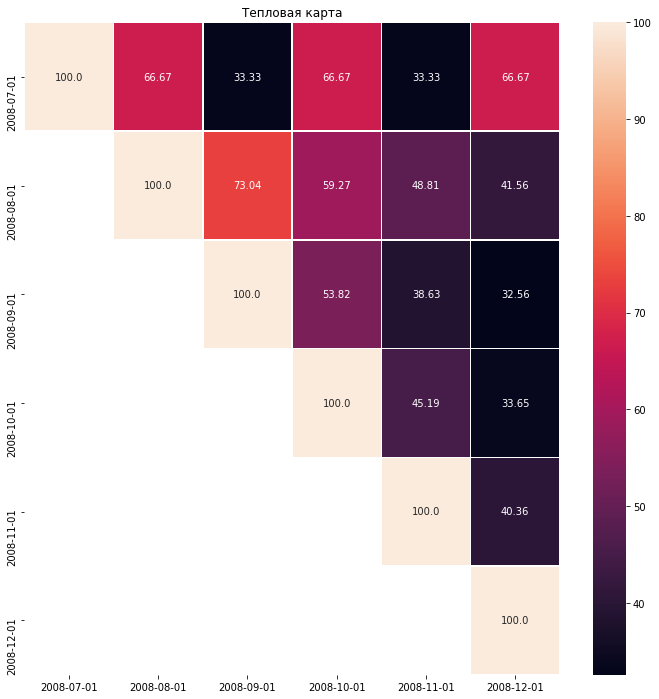

In [14]:
# создаём сводную таблицу с результатами
retention = data_8.pivot('cohort_dt', 'sessions_dt', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
# строим хитмэп
plt.figure(figsize=(12, 12)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            linewidths=.5, # добавляем линии
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

**Опишите аномалии или другие необычные явления и сформулируйте гипотезы**

1. Самый низкий процент возвращения для пользователей опубликовавших первый пост в Июле 2008
2. Самый высокий процент возвращения для пользователей опубликовавших первый пост в Августе 2008
3. Пользователи чаще возвращаются на следующий месяц после публикации первого поста.
4. Пользователи реже возвращаются через 2 месяца после публикации первого поста.
5. После месяца первой публикации пользователи реже возвращаются с каждым последующим месяцем.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [15]:
# напишите запрос
query9 = '''
SELECT creation_month,
       posts_count,
       percentage
FROM
(SELECT *,
       LAG(posts_count) OVER (ORDER BY creation_month) AS previous_posts_count,
       ROUND((CAST(posts_count - LAG(posts_count) OVER (ORDER BY creation_month) AS NUMERIC)/ (LAG(posts_count) OVER (ORDER BY creation_month)) * 100),2) AS percentage
FROM
    (SELECT EXTRACT(MONTH FROM sp.creation_date::DATE) AS creation_month,
           COUNT(sp.id) AS posts_count
    FROM stackoverflow.posts AS sp
    WHERE EXTRACT(MONTH FROM sp.creation_date::DATE) IN (9,10,11,12)
    GROUP BY EXTRACT(MONTH FROM sp.creation_date::DATE)) AS one_temp_table) AS two_temp_table
'''
# выполните запрос
data_9 = pd.read_sql_query(query9, con=engine) 
data_9.head()

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


<details>

<summary>Подсказка</summary>
Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.
</details>

**Постройте круговую диаграмму с количеством постов по месяцам**

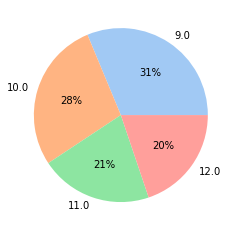

In [16]:
# исходные данные
pies = data_9.posts_count
labels = data_9.creation_month
# выберем цветовую палитру
colors = sns.color_palette('pastel')[0:4]
# строим диаграмму
plt.pie(pies, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
# напишите запрос
query10 = '''
SELECT dt_week,
       last_session
FROM 
    (SELECT EXTRACT(WEEK FROM sp.creation_date) AS dt_week,
           sp.creation_date,
           LAST_VALUE(sp.creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM sp.creation_date)) AS last_session
    FROM stackoverflow.posts AS sp
    WHERE EXTRACT(YEAR FROM sp.creation_date) = 2008
          AND EXTRACT(MONTH FROM sp.creation_date) = 10
          AND sp.user_id IN (SELECT user_id
                             FROM 
                                  (SELECT sp.user_id,
                                          COUNT(sp.id) As cnt
                                   FROM stackoverflow.posts AS sp
                                   GROUP BY sp.user_id
                                   ORDER BY cnt DESC
                                   LIMIT 1) AS one_temp)
    GROUP BY dt_week,
             sp.creation_date
    ORDER BY dt_week ASC,
             creation_date ASC) AS two_temp
GROUP BY dt_week,
         last_session
'''

# выполните запрос
data_10 = pd.read_sql_query(query10, con=engine) 
data_10.head()

,dt_week,last_session
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


<details>

<summary>Подсказка</summary>
Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.
</details>